In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Trial Matrix 

In [2]:
def generate_matrix(n, sigma):
    M1 = np.random.rand(n, n)
    M2 = np.random.rand(n, n)
    Q1, _ = np.linalg.qr(M1)
    Q2, _ = np.linalg.qr(M2)
    
    sig = np.array([sigma(k) for k in range(1, n+1)])
    Sigma = np.diag(sig)
    
    mat = Q1 @ Sigma @ Q2.T
    return mat

## Finding Probalities of Kth(row /col) of the matrix

In [3]:
def compute_probabilities(A, B):


    n = A.shape[1]
    pk = np.zeros(n)
    
    for k in range(n):
        norm_A = np.linalg.norm(A[:, k])
        norm_B = np.linalg.norm(B[k, :])
        pk[k] = norm_A**2 * norm_B**2
        
    total = np.sum(pk)
    
    pk = pk / total
    return pk


## Approximate Matrix Multiplication

In [4]:
def mat_mul(A, B, c, pk, method='random'):

    n = A.shape[0]
    M = np.zeros((n, n))
    
    if method == 'random':
        t = 0
        p_max = np.max(pk)
        while t <c:
            k = np.random.randint(0, n)
            U = np.random.rand()
            
            if p_max * U < pk[k]:
                t += 1
                M += np.outer(A[:, k], B[k, :]) / (c * pk[k])
                
    elif method == 'deterministic':
        indices = np.argsort(pk)[-c:]
        for k in indices:
            M += np.outer(A[:, k], B[k, :]) / (c * pk[k])
    
    return M



# Run the experiment

In [5]:

def run_experiment(m_class, n_vals, c_funcs, num_trials=10):
    errors_random = {key: [] for key in c_funcs}
    errors_deterministic = {key: [] for key in c_funcs}

    for n in n_vals:
        # Define the sigma function based on the matrix class.
        if m_class == 'II':
            sig = lambda k, n=n: np.exp(-(10*(k-1))/n)
        elif m_class == 'III':
            sig = lambda k, n=n: (n - k + 1) / n
        else:
            sig = lambda k: np.exp(-(k-1)/10)
        
        # Loop over each choice of c (different keys in c_funcs)
        for key, c_func in c_funcs.items():
            error_rand_sum = 0.0
            error_det_sum = 0.0
            c_roundoff = int(np.round(c_func(n)))
            
            for trial in range(num_trials):
                A = generate_matrix(n, sig)
                B = generate_matrix(n, sig)
                true_product = A @ B
                
                pk = compute_probabilities(A, B)
                
                M_rand = mat_mul(A, B, c_roundoff, pk, method='random')
                err_rand = np.linalg.norm(M_rand - true_product, 'fro') / np.linalg.norm(true_product, 'fro')
                error_rand_sum += err_rand
                
                M_det = mat_mul(A, B, c_roundoff, pk, method='deterministic')
                err_det = np.linalg.norm(M_det - true_product, 'fro') / np.linalg.norm(true_product, 'fro')
                error_det_sum += err_det
                
            errors_random[key].append(error_rand_sum / num_trials)
            errors_deterministic[key].append(error_det_sum / num_trials)
            
    return errors_random, errors_deterministic

# Experimental AnayaLysis

In [6]:
# Define matrix dimensions and c choices.
n_vals = [100, 200, 400, 800,1600]
c_funcs = {
    'c1': lambda n: np.log2(n),
    'c2': lambda n: (np.log2(n))**2,
    'c3': lambda n: 0.2 * n
}

# Run experiments for each matrix class
results = {}
for matrix_class in ['I',  'II', 'III']:
    errors_random, errors_deterministic = run_experiment(matrix_class, n_vals, c_funcs, num_trials=10)
    results[matrix_class] = {'random': errors_random, 'deterministic': errors_deterministic}


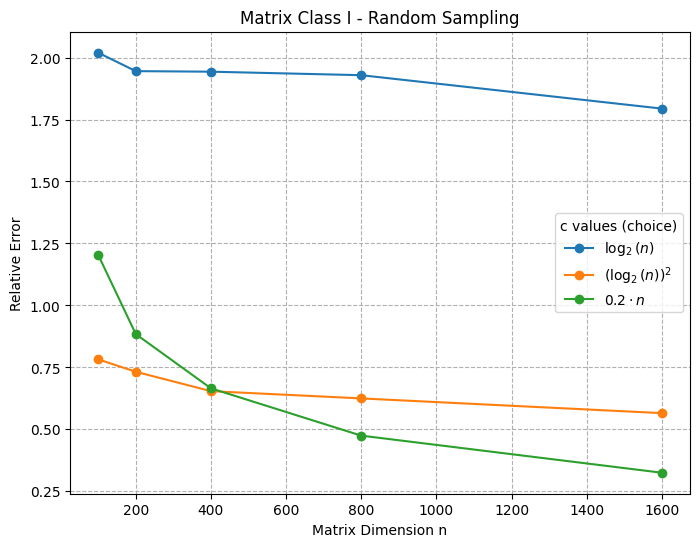

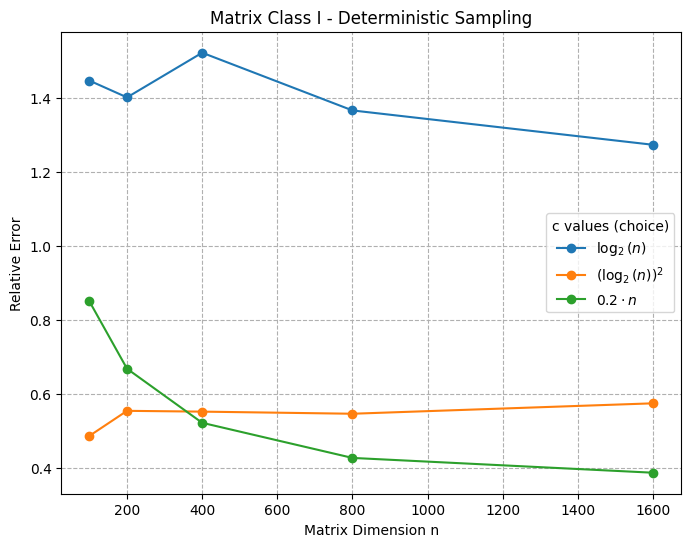

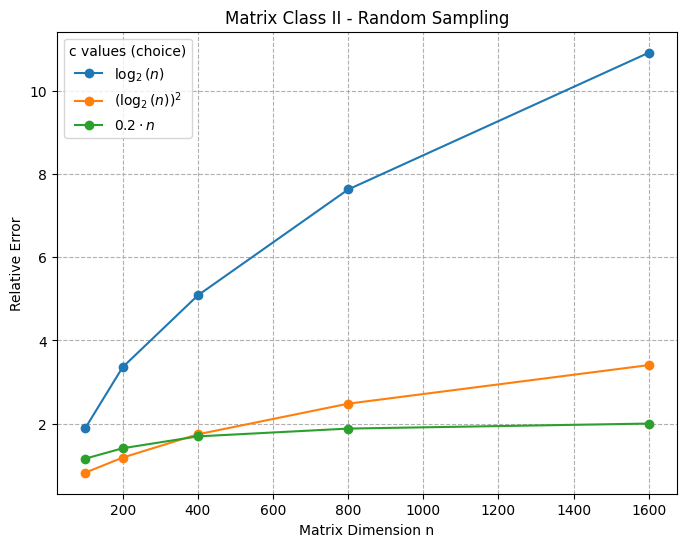

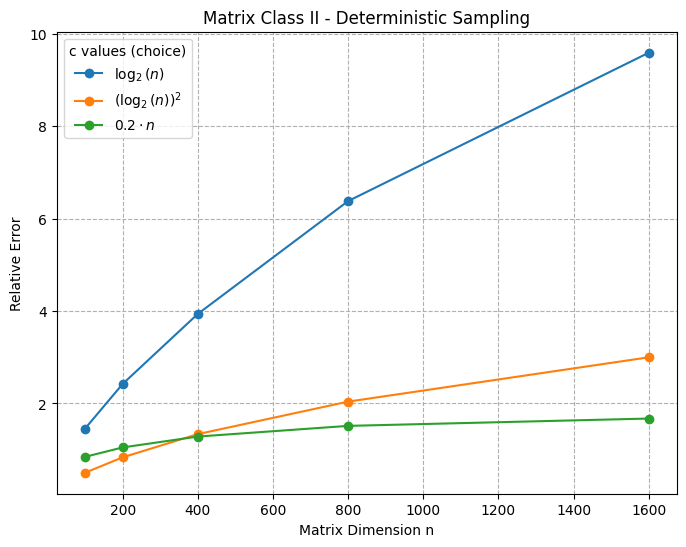

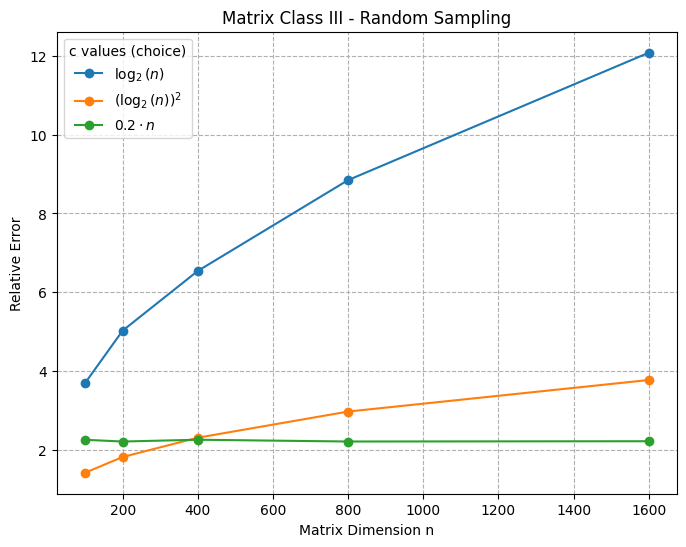

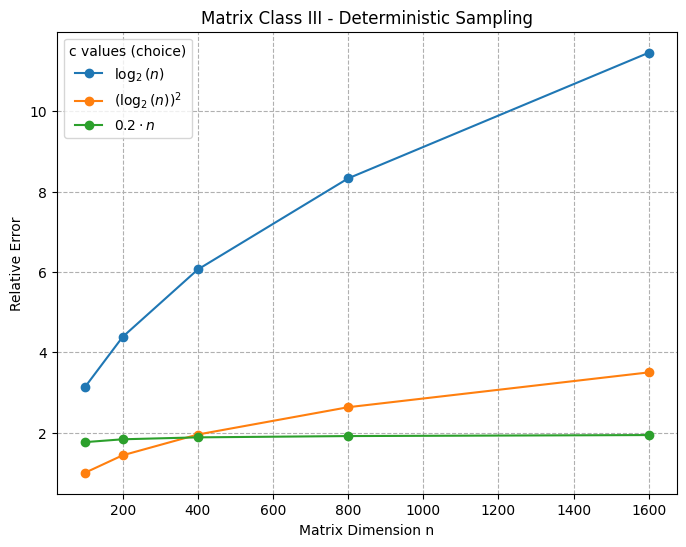

In [7]:

# Define custom labels for c values
labels = {
    'c1': r'$\log_2(n)$',
    'c2': r'$(\log_2(n))^2$',
    'c3': r'$0.2 \cdot n$'
}

# Plot results
for matrix_class in ['I', 'II', 'III']:
    for method in ['random', 'deterministic']:
        plt.figure(figsize=(8,6))
        for key in c_funcs:
            plt.plot(n_vals, results[matrix_class][method][key], marker='o', label=labels[key])
        plt.xlabel("Matrix Dimension n")
        plt.ylabel("Relative Error")
        plt.title(f"Matrix Class {matrix_class} - {method.capitalize()} Sampling")
        plt.legend(title="c values (choice)")
        plt.grid(True, which="both", ls="--")
        plt.show()

## OBSERVATIONS

- Increasing the number of samples \( c \) improves the approximation by incorporating more columns and rows, thereby reducing the relative error \( E \).
- With very few samples, the approximation suffers due to insufficient information, but as \( c \) increases, the error decreases noticeably.
- For matrix dimensions above 400, choosing \( c = 0.2n \) typically yields the best accuracy, while for smaller matrices, \( c = (\log_2 n)^2 \) tends to perform better.
- Larger matrix sizes inherently provide better statistical accuracy, leading to lower errors overall, with the most significant improvements occurring at smaller \( n \) before stabilizing.
- Deterministic sampling by selecting the top \( c \) columns and rows with the highest probabilities—consistently produces more stable and lower errors compared to random sampling.
